## RFM Analysis

In [18]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime

pd.set_option("display.max_columns",50)
%matplotlib inline
warnings.filterwarnings(action='ignore')

In [4]:
data = pd.read_csv('cust_trans_combined.csv')
data.head(3)

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,Profit,first_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,Age,Age_group,address,postcode,state,country,property_valuation
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,1970-01-01,17.87,Kristos,Male,19,1955-01-11,Software Engineer I,Financial Services,Mass Customer,N,Yes,10.0,68,70,984 Hoepker Court,3064,VIC,Australia,6
1,11065,1,2950,2017-10-16,0.0,Approved,Giant Bicycles,Standard,medium,medium,1403.50,954.82,1970-01-01,448.68,Kristos,Male,19,1955-01-11,Software Engineer I,Financial Services,Mass Customer,N,Yes,10.0,68,70,984 Hoepker Court,3064,VIC,Australia,6
2,18923,62,2950,2017-04-26,0.0,Approved,Solex,Standard,medium,medium,478.16,298.72,1970-01-01,179.44,Kristos,Male,19,1955-01-11,Software Engineer I,Financial Services,Mass Customer,N,Yes,10.0,68,70,984 Hoepker Court,3064,VIC,Australia,6


### Calculating R F and M values

#### 1. Recency
* The reference date I am considered is : 2023-12-31
* The difference between the reference date and maximum date in the dataframe for each customer(which is the recent visit) is Recency.

In [8]:
df_recency = data.groupby('customer_id',as_index=False)['transaction_date'].max()
df_recency.columns = ['customer_id','max_date']

df_recency.head()

,customer_id,max_date
0,1,2017-12-23
1,2,2017-08-24
2,4,2017-06-18
3,5,2017-12-14
4,6,2017-10-27


In [11]:
df_recency.dtypes

customer_id     int64
max_date       object
dtype: object

In [27]:
# changing dtype for max_date
df_recency['max_date'] = pd.to_datetime(df_recency['max_date'])

df_recency.dtypes

customer_id             int64
max_date       datetime64[ns]
dtype: object

In [39]:
ref_date = datetime.date(2023, 12, 31)
df_recency['Recency'] = df_recency['max_date'].apply(lambda d: (ref_date - d.date()).days)

#dropping max_date as recency has been calculated
df_recency.drop(['max_date'],axis=1,inplace=True)

In [40]:
df_recency.head()

,customer_id,Recency
0,1,2199
1,2,2320
2,4,2387
3,5,2208
4,6,2256


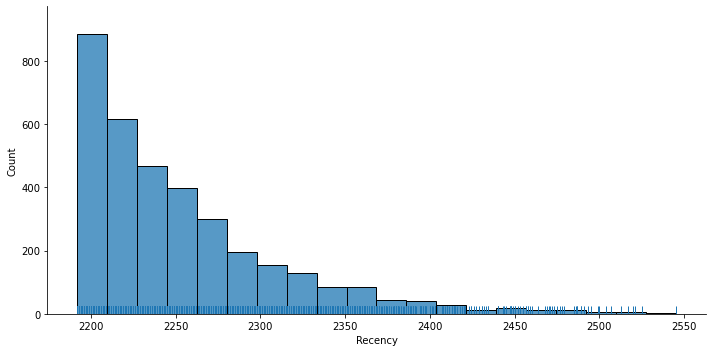

In [51]:
sns.displot(df_recency['Recency'],bins=20,rug=True,height=5,aspect=2)

* we can see the customers who order recently are more, and there are some customers who didnt order for more than an year. This way we can identify the customer and target them separately. But only recency value is not conclusive enough. 

#### 2. Frequency
* We can get the Frequency of the customer by summing up the number of orders.

In [53]:
df_frequency = data.groupby('customer_id',as_index=False)['transaction_id'].nunique()
df_frequency.columns = ['customer_id','frequency']
df_frequency.head()

,customer_id,frequency
0,1,11
1,2,3
2,4,2
3,5,6
4,6,5


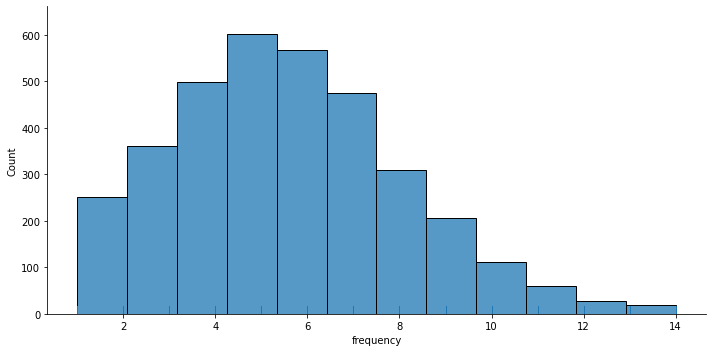

In [57]:
sns.displot(df_frequency['frequency'],bins=12,rug=True,height=5,aspect=2)

* we can see that most customers order order for 5 to 6 times, where as customers who order for more tham 10 times are really less.

#### 3. Monetary

* Monetary can be calculated as the sum of the Amount of all orders by each customer.

In [58]:
df_monetary = data.groupby('customer_id',as_index=False)['list_price'].sum()
df_monetary.columns = ['customer_id','Monetary']
df_monetary.head()

,customer_id,Monetary
0,1,9084.45
1,2,4149.07
2,4,1047.72
3,5,5903.20
4,6,5931.69


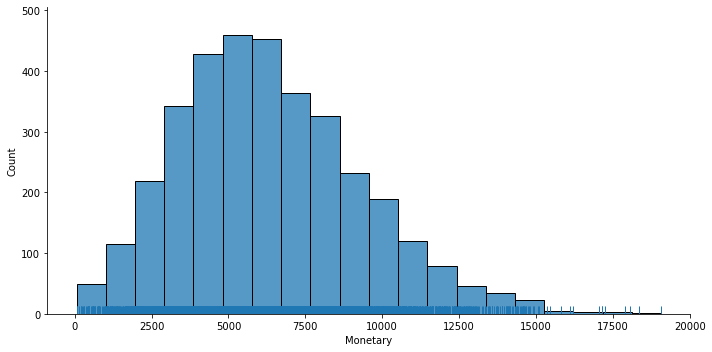

In [60]:
sns.displot(df_monetary['Monetary'],bins=20,rug=True,height=5,aspect=2)

* Most customers spend around 5000 to 6000 on, customers who spend more than 15k are really less, but we cannot segment anything based on this only monetary.
* Let’s merge the Recency, Frequency, and Monetary values and create a new dataframe.

In [65]:
df_rfm = pd.merge(df_frequency,df_recency,on='customer_id')
df_rfm = pd.merge(df_rfm,df_monetary,on='customer_id')

df_rfm.head()

,customer_id,frequency,Recency,Monetary
0,1,11,2199,9084.45
1,2,3,2320,4149.07
2,4,2,2387,1047.72
3,5,6,2208,5903.20
4,6,5,2256,5931.69


* using scatter plots to analyze the relationship among these three variables.

### Recency vs Frequency

Text(0.5, 1.0, 'Scatter Plot for Recency vs Frequency')

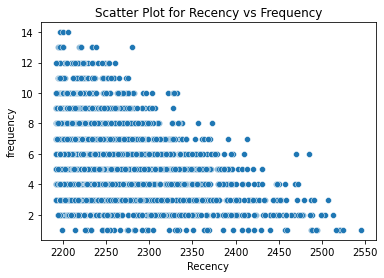

In [67]:
sns.scatterplot(df_rfm['Recency'],df_rfm['frequency'])
plt.title("Scatter Plot for Recency vs Frequency")

The customers who bought products more recently have more frequency.

### Frequency vs Monetary

Text(0.5, 1.0, 'Scatter Plot for Frequency vs Monetary')

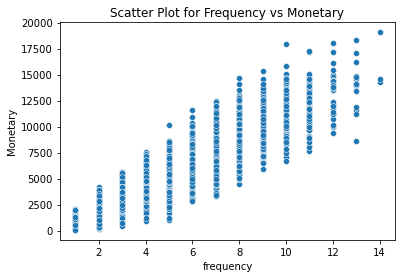

In [77]:
sns.scatterplot(df_rfm['frequency'],df_rfm['Monetary'])
plt.title("Scatter Plot for Frequency vs Monetary")

* The customers who brought more frequently have spent more money.

### Recency vs Frequncy vs Monetary

Text(0.5, 1.0, 'Scatter Plot for Recency vs Frequency vs Monetary')

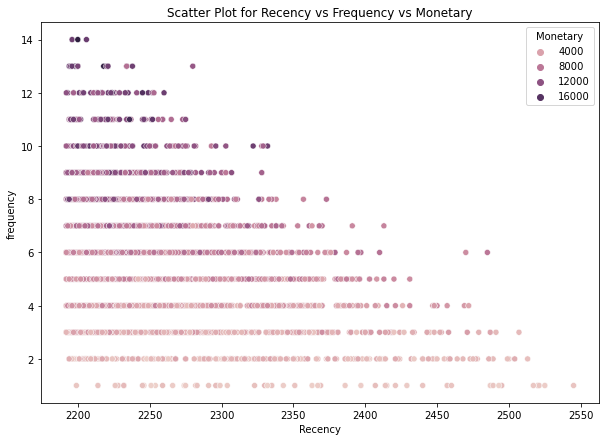

In [79]:
plt.figure(figsize=(10,7))
sns.scatterplot(df_rfm['Recency'],df_rfm['frequency'],hue=df_rfm['Monetary'])
plt.title("Scatter Plot for Recency vs Frequency vs Monetary")

From the above plot we can say that customers whose purchased recently have more frequency and spent more money.

### Calculating RFM scores.

#### R-Score

* For r score we can create thresholds based on the information, we are using 3 score segments 3 being the best to 1 being worst.
* so for 3 days less than 90, for 2 more than 90 and less than 210, anything more than 210 days can be considered as 1.
* since the data is not scaled for days 90 means 2290 and so on.

In [88]:
#function to calculate r-score
def r_score(row):
    if row['Recency'] <= 2290:
        return 3
    elif 2290 < row['Recency'] <= 2410:
        return 2
    else:
        return 1
    
df_rfm['R'] = df_rfm.apply(r_score,axis=1)
df_rfm.head()

,customer_id,frequency,Recency,Monetary,R
0,1,11,2199,9084.45,3
1,2,3,2320,4149.07,2
2,4,2,2387,1047.72,2
3,5,6,2208,5903.20,3
4,6,5,2256,5931.69,3


#### F-Score

* Same as R-score frequency ranges from 0 to 12 so dividing into 3 score segments as more frequent being 3 and less frequent being 1.
* Numerically 0-4 as 1, 5-8 as 2, anything more that as 3.

In [91]:
#function to calculate f-score
def f_score(row):
    if row['frequency'] <= 4:
        return 1
    elif 4 < row['frequency'] <= 8:
        return 2
    else:
        return 3
    
df_rfm['F'] = df_rfm.apply(lambda x: f_score(x), axis=1)
df_rfm.head()

,customer_id,frequency,Recency,Monetary,R,F
0,1,11,2199,9084.45,3,3
1,2,3,2320,4149.07,2,1
2,4,2,2387,1047.72,2,1
3,5,6,2208,5903.20,3,2
4,6,5,2256,5931.69,3,2


#### M-score

* Same for monetary also more value being the best and less value being worst.
* Numerically the range is from 0 - 20000, so 0-5000 as 3, 5k - 10k as 2, more than 10k as 3.

In [92]:
#function to calculate M-score
def m_score(row):
    if row['Monetary'] <= 5000:
        return 1
    elif 5000 < row['Monetary'] <= 10000:
        return 2
    else:
        return 3
    
df_rfm['M'] = df_rfm.apply(lambda x: m_score(x), axis=1)
df_rfm.head()

,customer_id,frequency,Recency,Monetary,R,F,M
0,1,11,2199,9084.45,3,3,2
1,2,3,2320,4149.07,2,1,1
2,4,2,2387,1047.72,2,1,1
3,5,6,2208,5903.20,3,2,2
4,6,5,2256,5931.69,3,2,2


* combined all the R, F and M score as text to get the 3 digit value.

In [94]:
def rfm_score(row):
    return str(row['R'])+str(row['F'])+str(row['M'])

df_rfm['RFM_score'] = df_rfm.apply(lambda x: rfm_score(x), axis=1)
df_rfm.head()

,customer_id,frequency,Recency,Monetary,R,F,M,RFM_score
0,1,11,2199,9084.45,3,3,2,332
1,2,3,2320,4149.07,2,1,1,211
2,4,2,2387,1047.72,2,1,1,211
3,5,6,2208,5903.20,3,2,2,322
4,6,5,2256,5931.69,3,2,2,322


In [95]:
df_rfm.dtypes

customer_id      int64
frequency        int64
Recency          int64
Monetary       float64
R                int64
F                int64
M                int64
RFM_score       object
dtype: object